### General advice (delete this cell before submitting for review)

> * When adding **Products used**, embed the hyperlink to that specific product on the DE Africa Explorer using the `[product_name](product url)` syntax.
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * To faciliate the easy conversion of these notebooks into a docs help page, check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DE Africa docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in hierarchical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
> * In the final notebook cell, include a set of relevant **keywords** which are used to build the DE Africa User Guide's [Keyword Index](https://docs.digitalearthafrica.org/en/latest/genindex.html).
    * Use the list of approved documentation keywords on the [wiki page](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/wiki/List-of-Documentation-Keywords).
    * Avoid using keywords that link to specific modules in `deafrica_tools`.
    * Use all lower-case (unless the tag is an acronym), separate words with spaces. Note that Sentinel satellites are canonically named with hyphens connecting name and number, while Landsat satellites are not: `sentinel-2`, `landsat 8`
    * Ensure the keywords cell below is in `Raw` format, rather than `Markdown` or `Code`.


# Urban area mapping for Sentinel 1 data using Kmeans Clustering

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Africa. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Africa helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Tools` package.

In [1]:
# Load the necessary packages. 

%matplotlib inline

import warnings 
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geojson
warnings.filterwarnings("ignore")

from collections import namedtuple
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from datacube.utils.geometry import assign_crs
from odc.algo import xr_reproject

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from skimage.exposure import equalize_adapthist

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.classification import sklearn_flatten
from deafrica_tools.classification import sklearn_unflatten

In [2]:
# Modules Listed in classifications.py
import os
import sys
import time
import joblib
import datacube
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm
import dask.array as da
import geopandas as gpd
from copy import deepcopy
import multiprocessing as mp
import dask.distributed as dd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod
from datacube.utils import geometry
from sklearn.base import ClusterMixin
from dask.diagnostics import ProgressBar
from rasterio.features import rasterize
from dask_ml.wrappers import ParallelPostFit
from sklearn.mixture import GaussianMixture
from datacube.utils.geometry import assign_crs
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import BaseCrossValidator

import warnings

from deafrica_tools.spatial import xr_rasterize

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='Urban_area_mapping')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are

* `central_lat`: The central latitude to analyse .
* `central_lon`: The central longitude to analyse .
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the part of Nairobi County, Kenya.


In [4]:
# Define the area of interest
lat = 14.72
lon = -17.355
lat_buffer = 0.15
lon_buffer = 0.2

# Combine lat, lon with their respective buffers to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# time frame for the analysis 
time_range = ('2020')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# View the study area 
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest. This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.


In [7]:
# Load the Sentinel-1 data
ds = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=time_range,
              output_crs = "EPSG:6933",
              resolution = (-10,10),
              group_by="solar_day"
             )

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 31 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [8]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 31, y: 3706, x: 3860)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:18:24.081937 ... 2020-12...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.839e+06 1.839e+06
  * x            (x) float64 -1.694e+06 -1.694e+06 ... -1.655e+06 -1.655e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.02642 0.02642 0.01632 ... 0.017 0.017
    vh           (time, y, x) float32 1.909e-05 1.909e-05 ... 0.0004507
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Apply speckle filtering

Radar observations appear speckly due to random interference of coherent signals from target scatters. 
The speckle noise can be reduced by averaging pixel values over an area or over time. 
However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution.
An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we apply the Lee filter, one of the popular adaptive speckle filters.


In [9]:
# Defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We've picked a default value for this analysis, but you can experiement with this if you're interested.

### Apply the Lee speckle filter to the Sentinel 1 dataset using a window size of 3

In [10]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = xr.ufuncs.isfinite(ds)
ds = ds.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds["filtered_vv"] = ds.vv.groupby("time").apply(lee_filter, size=3)
ds["filtered_vh"] = ds.vh.groupby("time").apply(lee_filter, size=3)

# Null pixels should remain null
ds['filtered_vv'] = ds.filtered_vv.where(valid.vv)
ds['filtered_vh'] = ds.filtered_vh.where(valid.vh)

## Convert the digital numbers (DN) values  to dB scale (logarithmic scale)

In [11]:
ds['filtered_vv'] = 10 * xr.ufuncs.log10(ds.filtered_vv)
ds['filtered_vh'] = 10 * xr.ufuncs.log10(ds.filtered_vh)

## Image selection 
From the Sentinel 1 dataset get the median of the time series for both the VH and VV polarization bands. 

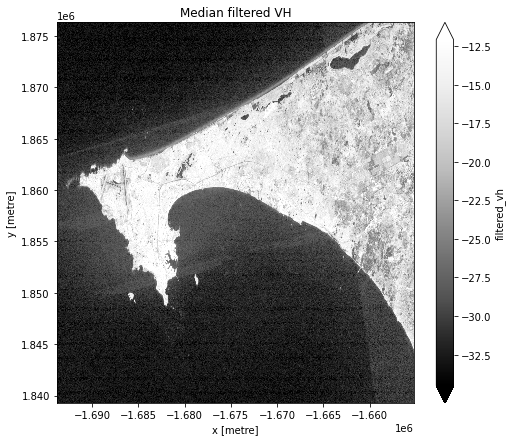

In [12]:
# Obtain the median of all VH observations for each pixel
median_vh = ds.filtered_vh.median(dim="time")

# Plot the median of all VH observations for each pixel
fig = plt.figure(figsize=(8, 7))
median_vh.plot(cmap="Greys_r", robust=True)
plt.title("Median filtered VH");

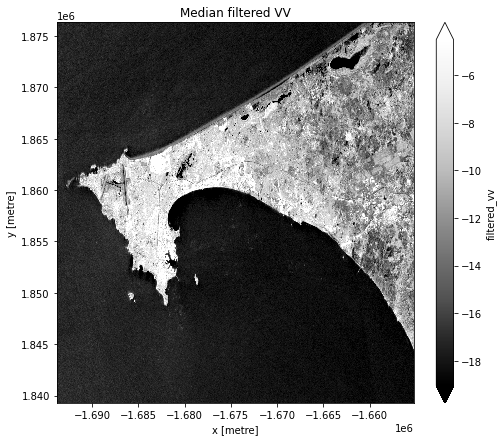

In [13]:
# Obtain the median of all the VV observations for each pixel
median_vv = ds.filtered_vv.median(dim="time")

# Plot the median of all VV observations for each pixel
fig = plt.figure(figsize=(8, 7))
median_vv.plot(cmap="Greys_r", robust=True)
plt.title("Median filtered VV");

Merge the median VH and VV polarization Data Arrays into one dataset

In [14]:
# Merge the median VH and VV polarization Data Arrays into one dataset
img = xr.merge([median_vh.rename('median_vh'), median_vv.rename('median_vv')])
img

<xarray.Dataset>
Dimensions:      (y: 3706, x: 3860)
Coordinates:
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.839e+06 1.839e+06
  * x            (x) float64 -1.694e+06 -1.694e+06 ... -1.655e+06 -1.655e+06
    spatial_ref  int32 6933
Data variables:
    median_vh    (y, x) float32 -33.38 -33.84 -34.28 ... -32.45 -33.59 -33.38
    median_vv    (y, x) float32 -16.56 -16.58 -16.6 ... -18.23 -18.53 -18.76

We can slice the ds dataset, that has 31 time steps to get a time series with 2 time steps for testing. 

In [15]:
ds_sel = ds[['filtered_vh', 'filtered_vv']].isel(time=[0,1])
print(ds_sel)                      

<xarray.Dataset>
Dimensions:      (time: 2, y: 3706, x: 3860)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:18:24.081937 2020-01-16T...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.839e+06 1.839e+06
  * x            (x) float64 -1.694e+06 -1.694e+06 ... -1.655e+06 -1.655e+06
    spatial_ref  int32 6933
Data variables:
    filtered_vh  (time, y, x) float32 -42.76 -37.14 -34.77 ... -23.72 -23.5
    filtered_vv  (time, y, x) float32 -16.75 -17.05 -17.38 ... -18.39 -18.11
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [16]:
ds_sel_vh = ds['filtered_vh'].isel(time=[0,1])
print(ds_sel_vh)                      

<xarray.DataArray 'filtered_vh' (time: 2, y: 3706, x: 3860)>
array([[[-42.756523, -37.1394  , -34.76985 , ..., -27.616375,
         -26.838045, -26.178522],
        [-40.608223, -34.691856, -32.276493, ..., -27.799273,
         -28.351858, -28.984753],
        [-40.794724, -33.541203, -30.960073, ..., -28.648184,
         -30.79794 , -35.23994 ],
        ...,
        [-31.785332, -33.367165, -35.880722, ..., -35.234688,
         -37.09152 , -40.40296 ],
        [-33.62384 , -35.364796, -38.315796, ..., -35.734413,
         -37.02329 , -38.86427 ],
        [-33.62384 , -35.364796, -38.315796, ..., -35.734413,
         -37.02329 , -38.86427 ]],

       [[-31.908998, -31.962559, -32.016796, ..., -29.590351,
         -29.159105, -28.766842],
        [-34.06042 , -32.974655, -32.10676 , ..., -28.709911,
         -28.643167, -28.57743 ],
        [-39.765854, -35.48623 , -33.373096, ..., -26.35072 ,
         -26.935863, -27.612305],
        ...,
        [-35.12563 , -34.930176, -34.74314 , ..

## Reshape a Dataset or Data Array into a numpy array

In [17]:
def raster_stack(input_xr):
    """
    Reshape a DataArray or Dataset with spatial structure spatial (and optionally
    temporal) structure into a numpy array with the spatial and optional temporal
    dimensions flattened into one dimension.

    This flattening procedure enables DataArrays and Datasets to be used
    to train and predict with sklearn models.

    Last modified: November 2021
    
    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    input_np : numpy.array
        A numpy array corresponding to input_xr.data (or
        input_xr.to_array().data), with dimensions 'x','y' and 'time'
        flattened into a single dimension, which is the first axis of
        the returned array.
    """
    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset() 
    
    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype
    
    # Get the number of bands in the input_xr Dataset.
    bands_list = list(input_xr.data_vars)
    nbands = len(bands_list)
    # Create a dictionary of the bands and their index in the list bands_list. 
    bands_dict = {k: v for k, v in enumerate(bands_list)}

    # Get the dimensions x and y of the input_xr Dataset.
    height = input_xr.dims['y']
    width = input_xr.dims['x']
    
    # Get the dimension time of the input_xr Dataset. 
    # Create an empty numpy array, model_input, in which each column will hold a
    # flattened band/measurement from the input_xr Dataset.
    if 'time' in input_xr.dims:
        time = input_xr.dims['time']
        model_input = np.empty((height * width * time, nbands), dtype=data_type)
    else:
        model_input = np.empty((height * width, nbands), dtype=data_type)
   
    # Loop through each band in the input_xr Dataset and add it 
    # to the numpy array model_input. 
    for i,band in bands_dict.items():
        band_array = np.array(input_xr[band])
        model_input[:, i-1] = band_array.flatten()
    
    return model_input

Time the sklearn_flatten and raster_stack functions on a dataset or data array with no time dimension.

The `img` dataset has 2 data variables/ bands and no time dimension.
The `median_vh` data array has 1 data variable/band and no time dimension.

In [18]:
%timeit sklearn_flatten(img)

620 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit raster_stack(img)

169 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit sklearn_flatten(median_vh)

301 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit raster_stack(median_vh)

85.8 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For a Dataset or Data Array with no time dimension, the raster_stack function is faster than  the sklearn_flatten function. 

In [26]:
print(img.to_array().shape)
print(sklearn_flatten(img).shape)
print(raster_stack(img).shape)

(2, 3706, 3860)
(14305160, 2)
(14305160, 2)


In [27]:
print(median_vh.shape)
print(sklearn_flatten(median_vh).shape)
print(raster_stack(median_vh).shape)

(3706, 3860)
(14305160,)
(14305160, 1)


Time the sklearn_flatten and raster_stack functions on a dataset or data array with the time dimension.

The `ds_sel` dataset has 2 data variables/ bands and a time dimension, 2 time steps.
The `ds_sel_vh` data array has 1 data variable/band and a time dimension, 2 time steps.

In [22]:
%timeit sklearn_flatten(ds_sel)

1.82 s ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit raster_stack(ds_sel)

334 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit sklearn_flatten(ds_sel_vh)

1.05 s ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit raster_stack(ds_sel_vh)

165 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
print(ds_sel.to_array().shape)
print(sklearn_flatten(ds_sel).shape)
print(raster_stack(ds_sel).shape)

(2, 2, 3706, 3860)
(28610320, 2)
(28610320, 2)


In [33]:
print(ds_sel_vh.shape)
print(sklearn_flatten(ds_sel).shape)
print(raster_stack(ds_sel).shape)

(2, 3706, 3860)
(28610320, 2)
(28610320, 2)


Time the 2 functions on the `ds[['filtered_vh', 'filtered_vv']]` that has 31 time steps and 2 data variables/bands/measurements.

In [34]:
%%time 
raster_stack(ds[['filtered_vh', 'filtered_vv']])

CPU times: user 2.64 s, sys: 2.48 s, total: 5.12 s
Wall time: 5.12 s


array([[-16.754257, -42.756523],
       [-17.053837, -37.1394  ],
       [-17.376038, -34.76985 ],
       ...,
       [-17.51044 , -28.673193],
       [-17.602512, -30.438421],
       [-17.696577, -33.461563]], dtype=float32)

Running the sklearn_flatten on the `ds[['filtered_vh', 'filtered_vv']]` dataset kills the kernel.

In [35]:
## %%time 
## sklearn_flatten(ds[['filtered_vh', 'filtered_vv']])

## Reshape a numpy array with no 'missing' elements (NaNs) and 'flattened' spatiotemporal structure into a Dataset matching the spatiotemporal structure of the input DataArray or Dataset

In [81]:
def prediction_dummy(input_xr):
    """
    Generate a dummy sklearn model prediction numpy array.
    
    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    output_np : numpy.ndarray
        A one dimensional empty numpy.ndarray with the size 'x' *'y'*'time'
        of the input_xr. 
    """
    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype
        
   # Get the dimensions x and y of the input_xr Dataset.
    height = input_xr.dims['y']
    width = input_xr.dims['x']
    
    # Get the time dimension of the input_xr Dataset.
    if 'time' in input_xr.dims:
        time = input_xr.dims['time']
        # Define an empty 1 dimensional numpy array to be a dummy 
        # output of a sklearn model prediction.
        output_np = np.empty((height * width * time ), dtype=data_type)
    else:
        # Define an empty 1 dimensional numpy array to be a dummy 
        # output of a sklearn model prediction.
        output_np = np.empty((height * width), dtype=data_type)
    
    return output_np

In [88]:
def raster_unstack(output_np, input_xr):
    """
    Reshape a numpy array with no 'missing' elements (NaNs) and
    'flattened' spatiotemporal structure into a DataArray matching the
    spatiotemporal structure of the DataArray

    This enables an sklearn model's prediction to be remapped to the
    correct pixels in the input DataArray or Dataset.

    Last modified: September 2019

    Parameters
    ----------
    output_np : numpy.array
        The first dimension's length should correspond to the number of
        valid (non-NaN) pixels in input_xr.
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    output_xr : xarray.DataArray
        An xarray.DataArray with the same dimensions 'x', 'y' and 'time'
        as input_xr, and the same valid (non-NaN) pixels. These pixels
        are set to match the data in output_np.

    """
    # The  expected output of a sklearn model prediction 
    # should just be a 1 dimensional numpy array, output_np, with the 
    # size/columns matching the height * width * time  for the 
    # dimensions of the input_xr DataArray/Dataset.
    
    # Cast the input DataArray to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Get the data type for the input_xr Dataset.
    data_type = input_xr.to_array().data.dtype
    
    # Get the dimensions x , y of the input_xr Dataset. 
    height = input_xr.dims['y']
    width = input_xr.dims['x']
    
    # Get the dimension time of the input_xr Dataset. 
    if 'time' in input_xr.dims:
        time = input_xr.dims['time']
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((time, height, width))
        # Convert the output_np numpy array into a xarray Dataset. 
        output_np_ds = xr.Dataset(
            data_vars=dict(band=(["time", "y", "x"], output_np)),
            coords=dict(time=(["time"], input_xr.coords['time'].values),
                        y=(["y"], input_xr.coords['y'].values),
                        x=(["x"], input_xr.coords['x'].values),
                        spatial_ref= input_xr.coords['spatial_ref'].values),
            attrs=input_xr.attrs)
    else:
        # Reshape the output_np numpy array
        output_np = output_np.reshape((height, width))
        # Convert the output_np numpy array into a xarray Dataset. 
        output_np_ds = xr.Dataset(
            data_vars=dict(band=(["y", "x"], output_np)),
            coords=dict(y=(["y"], input_xr.coords['y'].values),
                        x=(["x"], input_xr.coords['x'].values),
                        spatial_ref= input_xr.coords['spatial_ref'].values),
            attrs=input_xr.attrs)
    
    return output_np_ds

Time the sklearn_unflatten and raster_unstack functions on a dataset or data array with no time dimension.

The `img` dataset has 2 data variables/ bands and no time dimension.
The `median_vh` data array has 1 data variable/band and no time dimension.

In [83]:
input_xr = img
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

2.84 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
42.6 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
input_xr = median_vh
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

2.76 s ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
22.7 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For a Dataset or Data Array with no time dimension, the raster_unstack function is faster than  the sklearn_unflatten function.

Time the sklearn_flatten and raster_stack functions on a dataset or data array with the time dimension.

The `ds_sel` dataset has 2 data variables/ bands and a time dimension, 2 time steps.
The `ds_sel_vh` data array has 1 data variable/band and a time dimension, 2 time steps.

In [90]:
input_xr = ds_sel
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

1min 13s ± 525 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
83.3 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
input_xr = ds_sel_vh
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

1min 12s ± 605 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
42.2 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Time the 2 functions on the `ds[['filtered_vh', 'filtered_vv']]` that has 31 time steps and 2 data variables/bands/measurements.

In [93]:
input_xr = ds[['filtered_vh', 'filtered_vv']]
output_np = prediction_dummy(input_xr)

In [94]:
%%time
raster_unstack(output_np, input_xr)

CPU times: user 640 ms, sys: 592 ms, total: 1.23 s
Wall time: 1.23 s


<xarray.Dataset>
Dimensions:      (time: 31, y: 3706, x: 3860)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:18:24.081937 ... 2020-12...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.839e+06 1.839e+06
  * x            (x) float64 -1.694e+06 -1.694e+06 ... -1.655e+06 -1.655e+06
    spatial_ref  int32 6933
Data variables:
    band         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Urban area Classification using Kmeans Clustering 

In the next cell we will create a sets of functions which will together test a range of clusters for the Kmeans classification, store classified images and trained models and their evaluation metrics.

In [ ]:
class ClusteredBands:
    
    def __init__(self, img):
        self.img = img
        self.model_input = None
        self.width = 0
        self.height = 0
        self.nbands = 0
        self.no_of_ranges = None
        self.models = None
        self.predicted_rasters = None
        self.s_scores = []
        self.inertia_scores = []
        
    def set_raster_stack(self):
        
        # Get the number of bands in the image
        bands_list = list(self.img.data_vars)
        self.nbands = len(bands_list)
        
        # Get the dimensions of the image
        self.height = self.img.dims['y']
        self.width = self.img.dims['x']
        
        # Prepare the model input by first creating an empty array in which each column will hold a flattened band
        model_input = np.empty((self.height * self.width, self.nbands))
        
        # Loop through each band in the image and add it to the data array
        for i in range(self.nbands):
            for band in bands_list:
                band_array = np.array(self.img[band])
                model_input[:, i-1] = band_array.flatten()
        
        # Due to the large variation in the magnitude of the VH an VV polarization bands standardizing the data 
        scaler = StandardScaler()
        model_input = scaler.fit_transform(model_input)
        self.model_input = model_input
          
    def build_models(self, no_of_clusters_range):
        self.no_of_ranges = no_of_clusters_range
        models = []
        predicted = []
        inertia_vals = []
        s_scores = []
        for n_clust in no_of_clusters_range:
            kmeans = KMeans(n_clusters=n_clust,  init='k-means++')
            y_pred = kmeans.fit_predict(self.model_input)
            
            # Append model
            models.append(kmeans)
            
            # Calculate metrics
            s_scores.append(self._calc_s_score(y_pred))
            inertia_vals.append(kmeans.inertia_)
            
            # Append output image (classified)
            quantized_raster = y_pred.reshape((self.height, self.width))
            predicted.append(quantized_raster)
            
        # Update class parameters
        self.models = models
        self.predicted_rasters = predicted
        self.s_scores = s_scores
        self.inertia_scores = inertia_vals
        
    def _calc_s_score(self, labels):
        s_score = silhouette_score(self.model_input, labels, sample_size=1000)
        return s_score
        
    def show_clustered(self):
        for idx, no_of_clust in enumerate(self.no_of_ranges):
            title = 'Number of clusters: ' + str(no_of_clust)
            image = self.predicted_rasters[idx]
            plt.figure(figsize = (15,15))
            plt.axis('off')
            plt.title(title)
            plt.imshow(image, cmap=plt.cm.get_cmap('viridis', no_of_clust))
            cbar = plt.colorbar(ticks = np.unique(image), label='Pixel value')
            tick_locs =  (np.arange(no_of_clust) + 0.5)*(no_of_clust-1)/no_of_clust
            cbar.set_ticks(tick_locs)
            cbar.set_ticklabels(np.arange(no_of_clust))
            plt.show()
            
    def show_inertia(self):
        plt.figure(figsize = (10,10))
        plt.title('Inertia of the models in relation to the number of classes')
        plt.xlabel('Number of classes')
        plt.ylabel('Inertia Score')
        plt.plot(self.no_of_ranges, self.inertia_scores)
        plt.show()
        
    def show_silhouette_scores(self):
        plt.figure(figsize = (10,10))
        plt.title('Silhouette score in relation to the number of predicted classes')
        plt.xlabel('Number of classes')
        plt.ylabel('Silhouette score')
        plt.plot(self.no_of_ranges, self.s_scores)
        plt.show()

In [ ]:
clustered_models = ClusteredBands(img)
clustered_models.set_raster_stack()

In [ ]:
ranges = np.arange(2, 6, 1)
clustered_models.build_models(ranges)
clustered_models.show_clustered()
clustered_models.show_inertia()
clustered_models.show_silhouette_scores()

From a visual inspection of the resulting classifications the best number of categories to use for the classification is 3. 

In [97]:
# Function to conduct kmeans clustering on a Dataset or Dataarray using a specific number of clusters.
def kmeans_clustering(input_xr, no_of_clusters):
    # Use the raster_stack function to convert the Dataset into a 2 dimensional numpy array.
    model_input = raster_stack(input_xr)
    
    # Replace the np.nan values or np.inf values with 0. 
    model_input = np.nan_to_num(model_input, nan=0, posinf=0, neginf=0)
    # Due to the large variation in the magnitude of the VH an VV polarization 
    # standardizing the data. 
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Set up the kmeans classification by specifying the number of clusters 
    # with initialization as k-means++.
    km = KMeans(n_clusters=no_of_clusters, init='k-means++')

    # Begin iteratively computing the position of the clusters.
    km.fit(model_input)
    
    # Use the sklearn kmeans .predict method to assign all the pixels of the 
    # model input to a unique cluster.
    flat_predictions = km.predict(model_input)
    
    # Use the raster_unstack function to convert the flat predictions into a 
    # xarray Dataset.

    predicted_ds = raster_unstack(flat_predictions, input_xr)
    
    return predicted_ds

In [98]:
# Conduct kmeans clustering on the ds_sel dataset
n_clusters = 3
predicted_img = kmeans_clustering(ds_sel, n_clusters)
print(predicted_img)

<xarray.Dataset>
Dimensions:      (time: 2, y: 3706, x: 3860)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:18:24.081937 2020-01-16T...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.839e+06 1.839e+06
  * x            (x) float64 -1.694e+06 -1.694e+06 ... -1.655e+06 -1.655e+06
    spatial_ref  int32 6933
Data variables:
    band         (time, y, x) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [ ]:
X = raster_stack(ds_sel)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [ ]:
ds_sel.isnull().count()

In [ ]:
# Conduct kmeans clustering on the img dataset
n_clusters = 3
predicted_img = kmeans_clustering(img, n_clusters)
print(predicted_img)

In [ ]:
# Plot the predicted image. 
im = predicted_img.prediction_mask.plot(figsize=(15,15), cmap=plt.get_cmap('viridis', n_clusters), add_colorbar=False)
# Add colorbar
cbar = plt.colorbar(im, orientation="vertical")
tick_locs =  (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(n_clusters))
plt.title("Predicted mask");

From the plotted predicted image above, the most likely pixel value to represent the urban/buit up land cover class is the pixel value 2. 

In [ ]:
predicted_img = predicted_img == 2 
predicted_img

In [ ]:
# Remap the pixel values for the the predicted image such that True is value 1 and False is value 0 
def replace_with_dict2(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

In [ ]:
predicted_img.prediction_mask.values = replace_with_dict2(predicted_img.prediction_mask.values, {False:0 , True:1})
predicted_img

In [ ]:
predicted_img.prediction_mask.plot(figsize=(15,15), add_colorbar=False)
plt.title("Predicted mask");

## Comparison Metrics
We will compare the performance of the urban classification results against a built area (urban area) map for the study area derived from the ESA World Cover, global 10 m land use/land cover data from 2020. 

In [ ]:
# Load the ESA land use land cover product  from the  spatio-temporal extent as the Sentinel 1 dataset 
esa_lulc = dc.load(product='esa_worldcover',
                   like=ds.geobox, #match extent of ds
                   time=("2020")                   
                  ).squeeze()
print(esa_lulc)

In [ ]:
# Get the pixel value for each land cover class represented in the dataset
dc_measurements = dc.list_measurements()
esa_lulc_measurements = dc_measurements.loc[['esa_worldcover']]
esa_lulc_measurements.loc['esa_worldcover', 'classification'].flags_definition

In [ ]:
# Pixels with a value of 50 are classified as built up land cover. 
actual = esa_lulc["classification"] == 50
actual

In [ ]:
# Plot the land cover land use dataset
im = actual.plot(figsize=(8,7), add_colorbar=False)
plt.title('ESA Worldcover Built up areas (yellow)');

## Metric and Plotting Functions
The code below will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

In [ ]:
def get_metrics(actual, predicted, filter_size=1):
    """ Creates performance metrics.
    
    Args:
        actual: the data to use as truth.
        predicted: the data to predict and to compare against actual.
        filter_size: the filter size to apply on predicted to remove small object/holes with.
        
    Returns: A namedtuple containing the actual, predicted mask, and varying metrics for a confusion matrix.
    """
    metrics = namedtuple('Metrics',
                         'actual predicted true_positive true_negative false_positive false_negative')

    predicted  = remove_small_objects(predicted, min_size=filter_size+1, connectivity=2)
    predicted  = remove_small_holes(predicted, area_threshold=filter_size+1, connectivity=2)

    true_positive=(predicted & actual).sum()
    true_negative=(~predicted & ~actual).sum()
    false_positive=(predicted & ~actual).sum()
    false_negative=(~predicted & actual).sum()

    return metrics(actual=actual,
                   predicted=predicted,
                   true_positive=true_positive,
                   true_negative=true_negative,
                   false_positive=false_positive,
                   false_negative=false_negative)

def print_metrics(metrics):
    norm = metrics.true_positive + metrics.false_negative + metrics.false_positive + metrics.true_negative
    accuracy = (metrics.true_positive + metrics.true_negative)/norm
    ppv = metrics.true_positive/(metrics.true_positive + metrics.false_positive)
    tpr = metrics.true_positive/(metrics.true_positive + metrics.false_negative)
    f1 = (2*ppv*tpr)/(ppv+tpr)
    
    print('True Positive (Actual + Model = Urban): {tp}'.format(tp=round(metrics.true_positive/norm*100,3)))
    print('True Negative (Actual + Model = Non-Urban): {tn}'.format(tn=round(metrics.true_negative/norm*100,3)))
    print('False Positive (Actual=Non-Urban, Model=Urban): {fp}'.format(fp=round(metrics.false_positive/norm*100,3)))
    print('False Negative (Actual=Urban, Model=Non-Urban): {fn}'.format(fn=round(metrics.false_negative/norm*100,3)))
    print('\nAccuracy: {accuracy}'.format(accuracy=round(accuracy*100, 3)))
    print('F1 Score: {f1}\n'.format(f1=round(f1*100, 3)))

In [ ]:
print ('\033[1m' + '\033[91m' + 'Urban Area Mapping Clustering Results') # bold print and red
print ('\033[0m') # stop bold and red
metrics = get_metrics(actual.values, predicted_img.prediction_mask.values)
print_metrics(metrics)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')